## GPU setting

In [1]:
import os
import sys 
GPU = '0'
os.environ["CUDA_VISIBLE_DEVICES"] =  GPU 
''
%load_ext autoreload
%autoreload 2

## Load data file - filtering - parameter assignments

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.io as sio
from sklearn import preprocessing
from scipy.signal import lfilter
from scipy import signal
import random
from utilities import *

# optimization parameters
lambda_reg = 0.0    # if 0.0, no regularization
threshold = 1e-3    # change in objective function between two iterations
lrn_rate = 0.0001   # learning rate for GD
iter = 100          # Iterations
a_max = 1.00        # maximum step-size (2)
inv_typ = 2         # 1 for direct inversion, 2 for pseudo inversion
C1, C2 = 1e-4, 0.9  # Parameters for Line Search
corr_id = 33        # DOF of reference response for cross-correlation, for instance, if M = 100, set this to 50 for 1st mode, 25 for 2nd, and 33 for third (37)
win = 30            # 50 for window size gives 3 modes (30) 25

# additive noise
# noise_lvl = 0.10

# number of vehicles
num_vcl = 125
num_sns = 0

## ----------- READING DATA & SCALING ----------- ## 

'''
# Point to the text file of bridge response (the text file 
contains bridge responses at all DOFs - each column is a DOF)
'''
f = open('Accel_42.txt', 'r+')  
triplets = f.read().split()
f.close()
Y = np.zeros((4999,5000))
for i in range(4999):
    Y[i,:] = triplets[i*4999:i*4999+5000]
Y = np.append(Y, np.zeros((1,5000)), axis=0) 

Y = Y*10**9
Y = Y.T
N, M = Y.shape
loc_vec = np.arange(1,M)
time_vec = np.arange(1,N)
Y_shrunk = Y
T = 100  # Total time from response matrix
dt = float(T)/N
print ('dt before downsampling = ', dt)

temp = []
loc_vec = np.arange(0,M,1)
time_vec = np.arange(0,N,1)
time_vec = np.arange(0,N,1)
Y_shrunk = np.squeeze(Y[[loc_vec],:])
Y_shrunk = np.squeeze(Y_shrunk[:,[time_vec]])
M, N = np.shape(Y_shrunk)
dt = float(T)/N
dt = float(T)/N
print ('dt after downsampling = ', dt)

## ----------- SIGNAL WINDOWING ----------- ## 

w = np.bartlett(win)   
for i in range(len(Y_shrunk[:,30])):
    Y_shrunk[i,:] = np.convolve(w/w.sum(),Y_shrunk[i,:],'same') 

## ----------- SIGNAL FILTERING ----------- ## 

order = 20
fs = 1/dt       # sample rate, Hz
cutoff = 3.0    # desired cutoff frequency of the filter, 2.7 Hz
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
Y_shrunk = lfilter(b, a, Y_shrunk)

## ----------- PLOT A DOF IN TIME & FREQ ----------- ## 

plt.figure('psd')
plt.psd(Y_shrunk[800,:], 2048, 1 / dt)
plt.xlim((0,5))
plt.show()

# Rank
K_est = 5 # keep it small to get more clear modes [5 ~ 10]

plt.figure()
plt.plot(Y_shrunk[800,:])
plt.show()

dt before downsampling =  0.02
dt after downsampling =  0.02


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [3]:
M,N = Y_shrunk.shape
print('matrix dimension:',M,N)

matrix dimension: 5000 5000


percentage of available data:  1.194304 %


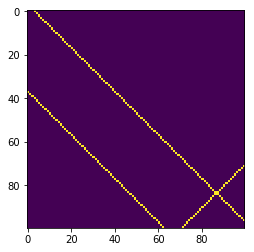

In [4]:
## --------------- Permulation Matrix --------------- ##

'''
In this block, the function diagNS randomly selects entries from the matrix
to simulate the random observations of moving vehicles. The vehicles have random 
speed, direction, and starting time. 
'''
def diagNS(diagList, dirList, spdList, snsList):
  perm = np.zeros((N+M,M))
  for j in range(len(diagList)):
    k = diagList[j]
    sp = spdList[j]
    if dirList[j] >= 0.5:
      c = 0
      for i,row in enumerate(perm):
        if k <= i < len(row) + k and i % sp == 0:
          row[c] = 1
          c += 1
      perm[i] = row
    if dirList[j] < 0.5:
      c = M-1
      for i,row in enumerate(perm):
        if -k >= -i > -len(row)-k and i % sp == 0:
          row[c] = 1
          c -= 1
      perm[i] = row
  perm = perm[M:,:].T
  perm[snsList,:] = 1
  perm = perm.astype(int)
  return perm 

dirList = np.random.random((num_vcl, 1))
diagList = np.random.randint(M+N, size = (num_vcl, 1))
spdList = np.random.randint(low = 1, high = 2, size = (num_vcl, 1))
snsList = np.linspace(0 ,M, num_sns+2)[1:-1].astype(int)
perm = diagNS(diagList, dirList, spdList, snsList)

print("percentage of available data: ",(perm==1).sum()/float(M)/N*100,"%")
plt.imshow(perm[500:600,500:600].T)

## i,j of observed data

I,J = np.where(perm == 1)
Y_obs = np.multiply(Y_shrunk,perm)         # Observed Matrix (Y_org .* perm)


## 1. Free Optimization (ALS)

In [5]:
'''
In this block, the optimization problem for matrix completion is introduced.
Loss function is not regulated since it wasn't necessary.

maxIter = maximum number of iterations
threshold = stopping criterion on the variation of gradiant
'''
mat,W1,W2,loss_val = ALS_Optimization(Y_obs,K_est,perm,threshold,maxIter=2000)

W0309 13:03:11.262859 140474213176256 deprecation_wrapper.py:119] From utilities.py:14: The name tf.InteractiveSession is deprecated. Please use tf.compat.v1.InteractiveSession instead.

W0309 13:03:12.502525 140474213176256 deprecation_wrapper.py:119] From utilities.py:25: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0309 13:03:13.724781 140474213176256 deprecation_wrapper.py:119] From utilities.py:30: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.

W0309 13:03:13.741184 140474213176256 deprecation_wrapper.py:119] From utilities.py:31: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0309 13:03:17.628896 140474213176256 deprecation_wrapper.py:119] From utilities.py:48: The name tf.train.GradientDescentOptimizer is deprecated. Please use tf.compat.v1.train.GradientDescentOptimizer instead.



initial loss function value:  1551509429.7408683
loss function value:  1549812799.551286
loss function value:  1548087096.863647
loss function value:  1546197222.4286568
loss function value:  1544000745.6712139
loss function value:  1541334673.140194
loss function value:  1538001454.3580077
loss function value:  1533753153.550269
loss function value:  1528272861.8227866
loss function value:  1521152637.6085868
loss function value:  1511867680.8427885
loss function value:  1499747277.6686466
loss function value:  1483944609.9083805
loss function value:  1463410234.1955214
loss function value:  1436878383.0763402
loss function value:  1402881528.1790729
loss function value:  1359816402.664319
loss function value:  1306091509.9149942
loss function value:  1240386084.994807
loss function value:  1162032910.5421495
loss function value:  1071489573.0764731
loss function value:  970780791.6668893
loss function value:  863704191.85466
loss function value:  755564755.5794488
loss function value

loss function value:  73720054.83126621
loss function value:  73000052.94567783
loss function value:  72292083.7176987
loss function value:  71596067.70126998
loss function value:  70911915.50727838
loss function value:  70239528.31797947
loss function value:  69578798.41096279
loss function value:  68929609.69002977
loss function value:  68291838.22050849
loss function value:  67665352.76666993
loss function value:  67050015.32903533
loss function value:  66445681.67947887
loss function value:  65852201.892137565
loss function value:  65269420.868238695
loss function value:  64697178.853052735
loss function value:  64135311.943275295
loss function value:  63583652.583238274
loss function value:  63042030.04845108
loss function value:  62510270.91507672
loss function value:  61988199.514059305
loss function value:  61475638.36873508
loss function value:  60972408.6148828
loss function value:  60478330.40229825
loss function value:  59993223.27711129
loss function value:  59516906.54420

loss function value:  25301873.397695698
loss function value:  25212853.84833535
loss function value:  25124398.97388941
loss function value:  25036505.13042571
loss function value:  24949168.66194594
loss function value:  24862385.901108637
loss function value:  24776153.169976186
loss function value:  24690466.780783165
loss function value:  24605323.03672317
loss function value:  24520718.23275141
loss function value:  24436648.656400762
loss function value:  24353110.588608615
loss function value:  24270100.304552484
loss function value:  24187614.074491933
loss function value:  24105648.164615057
loss function value:  24024198.837887358
loss function value:  23943262.35490124
loss function value:  23862834.974724427
loss function value:  23782912.955745727
loss function value:  23703492.55651644
loss function value:  23624570.036586262
loss function value:  23546141.6573322
loss function value:  23468203.682779234
loss function value:  23390752.38041182
loss function value:  23313

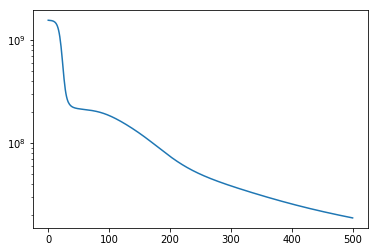

In [6]:
## Loss function vs. iteration
plt.semilogy(loss_val)

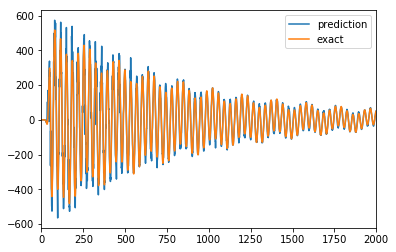

In [7]:
'''
Y_ALS contains the approximated respose matrix. 
Plots compare approximations with actual ones.
'''
Y_ALS = mat
plt.figure('predict vs. actual')
plt.plot(Y_ALS[2500,:])
plt.plot(Y_shrunk[2500,:])
plt.xlim([0,2000])
plt.legend(['prediction','exact'])
plt.show()

In [8]:
A_est = W1
B_est = W2

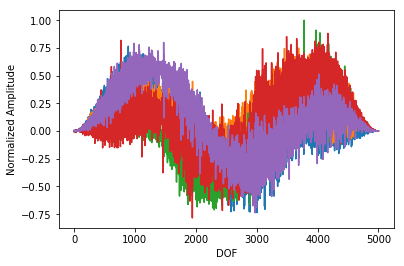

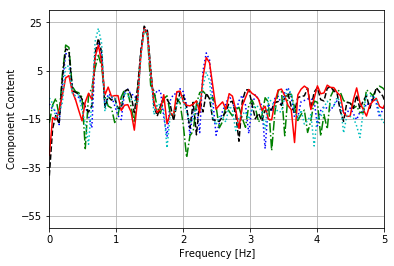

In [9]:
plt.plot(A_est/A_est.max())
plt.xlabel('DOF')
plt.ylabel('Normalized Amplitude')
plt.show()

color = ["b","g","k","r","c",'w']
marker = [':',"-.","--","-",":","-."]
for i in range(K_est):
    plt.psd(B_est[:,i],1024,1/dt,color=color[i],linestyle=marker[i])
plt.xlim([0,5]) 
plt.yticks((-55,-35,-15,5,25))
plt.ylim([-60,30])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Component Content')
plt.show()

Component ID: 1


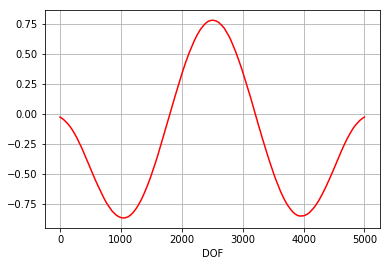

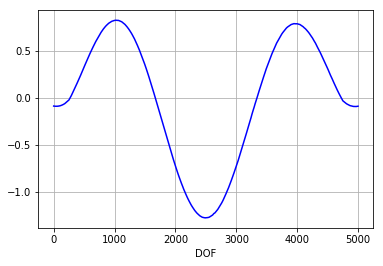

Component ID: 2


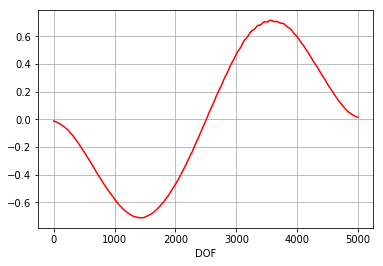

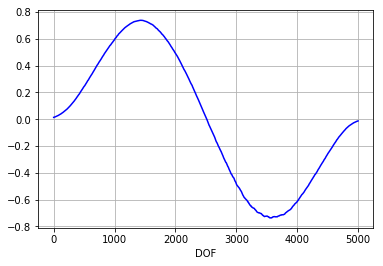

Component ID: 3


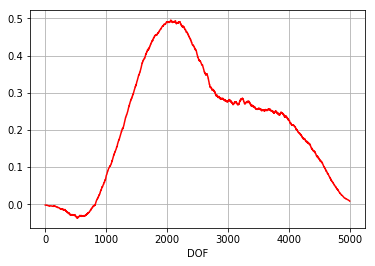

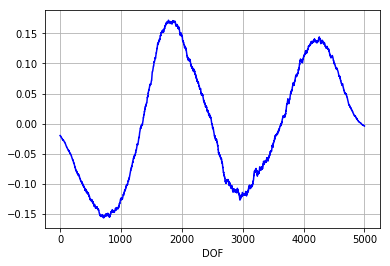

Component ID: 4


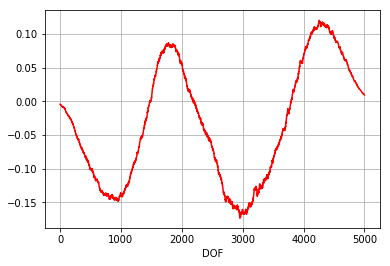

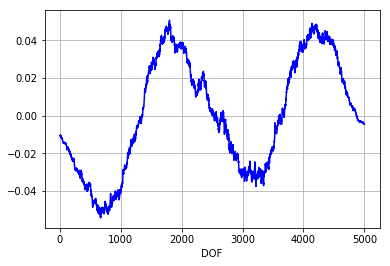

In [14]:
from scipy import signal
from sklearn.decomposition import PCA

K_final = 4
pca = PCA(n_components=K_final)
S_1 = pca.fit(B_est).transform(B_est)
A1_unmap = pca.transform(A_est)
A2_unmap = pca.fit(A_est).transform(A_est)
S_2 = pca.transform(B_est)

avg = 500
plt.figure('real modes')
for i in range(K_final):
    print('Component ID:',str(i+1))
    plt.plot(np.convolve(A1_unmap[:,i]/min(A1_unmap[:,i]), np.ones((avg,))/avg, mode='same'),'r'); 
    plt.grid()
    plt.xlabel('DOF')
    plt.show()
    plt.plot(np.convolve(A2_unmap[:,i]/min(A2_unmap[:,i]), np.ones((avg,))/avg, mode='same'),'b'); 
    plt.grid()
    plt.xlabel('DOF')
    plt.show()

1 2 4
2 1 2
3 1 1
4 2 3


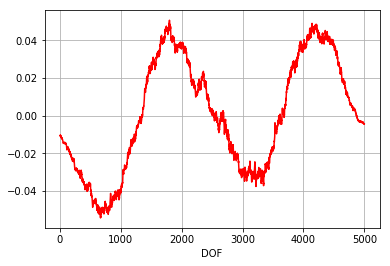

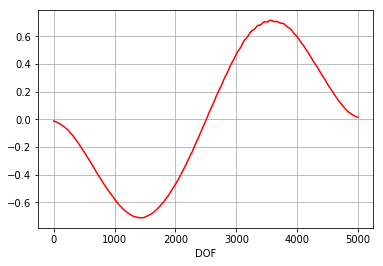

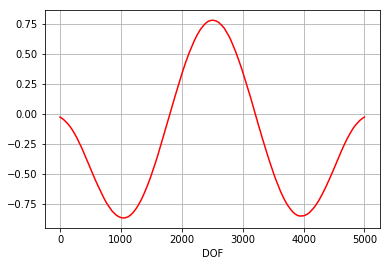

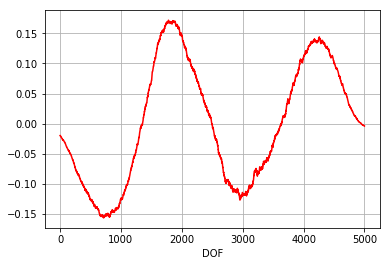

In [15]:
'''
ids contains tuples with these entries: (1) mode number, (2) 1 for blue, 2 for red, (3) number of component
These have to be picked from the previous cell. 
NOTE: this process is optional, not very smart yet. Will be automated in the next release.
'''

ids = [(1,2,4),(2,1,2),(3,1,1),(4,2,3)]
K_final = 4

A_unmap = np.zeros((5000,4))
S_ = np.zeros((5000,4))
for i,j,k in ids:
    print (i,j,k)
    if j == 1:
        A_unmap[:,i-1] = A1_unmap[:,k-1]
        S_[:,i-1] = S_1[:,k-1]
    if j == 2:
        A_unmap[:,i-1] = A2_unmap[:,k-1]
        S_[:,i-1] = S_2[:,k-1]

for i in range(K_final):
    plt.plot(np.convolve(A_unmap[:,i]/min(A_unmap[:,i]), np.ones((avg,))/avg, mode='same'),'r'); 
    plt.grid()
    plt.xlabel('DOF')
    plt.show()        

In [17]:
'''
calculates MAC values. It's a very manual function. So, please don't use it. 
It's here just as a reference. Will be automated in the future release.
'''
from scipy import interpolate

def macFinder(vec,vecx,mode):
    x1 = np.array([0,0.05,0.1,0.2,0.3,0.4,0.5,\
                  0.6,0.7,0.8,0.9,0.95,1.0])
    if mode == 0:
        v1 = np.array([0,1.24523E-05,4.57119E-05,0.000149764,0.000264796,0.000351056,\
                       0.000382142,0.000349283,0.000262407,0.000148021,4.51279E-05,1.23074E-05,0])
    elif mode == 1:
        v1 = np.array([0,3.2093E-05,0.000109361,0.000289783,0.000361408,0.000247792,\
                       -1.31867E-06,-0.000250093,-0.00036299,-0.00029068,-0.000109724,-3.22561E-05,0])
    elif mode == 2:
        v1 = -1*np.array([0,-5.92165E-05,-0.000185035,-0.000362711,-0.000209103,0.000151082,\
                          0.000338181,0.000151022,-0.000209113,-0.000362806,-0.000185262,-5.94074E-05,0])
    elif mode == 3:
        v1 = -1*np.array([0,-9.16667E-05,-0.00025823,-0.000317542,0.000101368,0.000335169,\
                          3.12498E-08,-0.000335286,-0.000101736,0.000317402,0.000258537,9.19719E-05,0])
    f = interpolate.interp1d(x1, abs(v1))
    vNew = f(vecx)
    vR = abs(vec)
    output = np.power(abs(np.matmul(vR.T, vNew)),2)/np.matmul(vR.T,vR)/np.matmul(vNew.T,vNew)
    return output

mac = []

if num_vcl == 75:
    temp = [0,1,2,3]
elif num_vcl == 100:
    temp = [0,1,2,3]
else:
    temp = [0,1,2,3]
    
for i in range(K_final):
    vec = np.convolve(A_unmap[:,temp[i]]/min(A_unmap[:,temp[i]]), np.ones((avg,))/avg, mode='same')
    vecx = np.linspace(0,1,5000)
    mode = i
    mac.append(macFinder(vec,vecx,mode))
    print ('MAC val mode ', str(i), ': ', mac[-1])

    
# File = open(("42_ALS"+str(num_vcl)+"_MAC.txt"),"w") 
# File.write(repr(mac))   
# File.close()

MAC val mode  0 :  0.46053298334248766
MAC val mode  1 :  0.9987149599067671
MAC val mode  2 :  0.9580348769120224
MAC val mode  3 :  0.9128329747867817


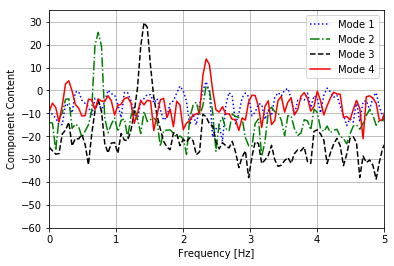

In [18]:
dt = T/float(M)
plt.figure('psd')
for i in range(K_final):
  plt.psd(S_[:,temp[i]] - np.mean(S_[:,temp[i]]), 1024, 1 / dt, color=color[i],linestyle=marker[i])
  plt.xlim([0,5])
  plt.ylim([-60,35])
  plt.yticks((-60,-50,-40,-30,-20,-10,0,10,20,30))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Component Content') 
plt.legend(['Mode 1','Mode 2','Mode 3','Mode 4'])
# plt.savefig(("42_ALS"+str(num_vcl)+"_FICAModes_psdModes.eps"), dpi=600)
plt.show()

In [19]:
'''
Manual damping ratio estimation using decay of motion rule
'''
# Decay of motion for damping estimation using ALS:

# # Mode 1
# u_i = 6.5 # 11.5 for 125
# u_j = 2.2  # 3.5 for 125
# # plt.plot(S_[:,temp[0]]); plt.xlim([910,2448]); plt.ylim([-u_i,u_i]); plt.grid(); plt.show()
# # plt.plot(S_[:,temp[0]]); plt.xlim([2440,2700]); plt.ylim([-u_j,u_j]); plt.show()
# j = 8 # 9 for 125
# damp_1 = 1/(2*np.pi*j)*np.log(u_i/u_j)
# print "Damping Ratio Mode 1: ", damp_1*100

# # Mode 2
# u_i = 8.5 # 8.2 for 125
# u_j = 4.0 # 3.9 for 125
# # plt.plot(S_[:,temp[1]]); plt.xlim([1105,2000]); plt.ylim([-u_i,u_i]); plt.grid(); plt.show()
# # plt.plot(S_[:,temp[1]]); plt.xlim([2000,2300]); plt.ylim([-u_j,u_j]); plt.show()
# j = 13 # 13 for 125
# damp_2 = 1/(2*np.pi*j)*np.log(u_i/u_j)
# print "Damping Ratio Mode 2: ", damp_2*100

# # Mode 3
# u_i = 14.4 # 14.3 for 125
# u_j = 7.9  # 7.9 for 125
# # plt.plot(S_[:,temp[2]]); plt.xlim([1003,1458]); plt.ylim([-u_i,u_i]); plt.show()
# # plt.plot(S_[:,temp[2]]); plt.xlim([1458,1700]); plt.ylim([-u_j,u_j]); plt.show()
# j = 13 # 13 for 125
# damp_3 = 1/(2*np.pi*j)*np.log(u_i/u_j)
# print "Damping Ratio Mode 3: ", damp_3*100

# # Mode 4
# u_i = 9.7 # 5.0 for 125
# u_j = 4.8 # 3.2 for 125
# # plt.plot(S_[:,temp[3]]); plt.xlim([610,875]); plt.ylim([-u_i,u_i]); plt.show()
# # plt.plot(S_[:,temp[3]]); plt.xlim([870,950]); plt.ylim([-u_j,u_j]); plt.show()
# j = 12 # 14 for 125
# damp_4 = 1/(2*np.pi*j)*np.log(u_i/u_j)
# print "Damping Ratio Mode 4: ", damp_4*100

# DAMP = np.array([damp_1,damp_2,damp_3,damp_4])
# # File = open(("42_ALS"+str(num_vcl)+"_DAMP.txt"),"w") 
# # File.write(repr(DAMP))   
# # File.close()

'\nManual damping ratio estimation using decay of motion rule\n'

## 2. Structured Optimization:

Structured optimization is proposed to extract natural modes directly from impulse responses. It has the following advantages: 

1- No intermodal leakage is possible. 

2- Mode orthogonality is guaranteed. 

3- Outperforms PCA in terms of accuracy of identified modes.


In [20]:
'''
Re-initalizing input matrix
'''

M, N = Y_shrunk.shape

dt = float(T)/N
print ('dt before resampling = ', dt)

YY = Y_ALS
loc_vec = np.arange(0,M,50)
time_vec = np.arange(0,N,1)
YY = np.squeeze(Y_ALS[[loc_vec],:])
YY = YY/np.max(np.abs(YY))*0.01
M, N = np.shape(YY)
dt = float(T)/N
print ('dt after resampling = ', dt)

dt before resampling =  0.02
dt after resampling =  0.02


100 5000


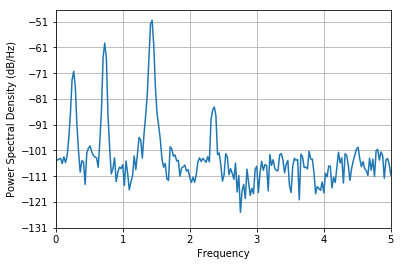

In [21]:
'''
signal windowing to smooth it down a little bit
'''

win2 = 10

w = np.bartlett(win2)   # bartlett or hamming are good
plt.psd(YY[10,:],2048,1/dt)
plt.xlim([0,5])

print (M,N)

In [22]:
'''
IMPORTANT: Structured optimization needs frequency initiation.
This is not a very limiting constraint. The initial values can 
be set by peak-picking from PSD.
'''
bf_est = np.array([0.26, 0.73, 1.40, 2.35, 3.5, 4.45, 5.5, 6.5])       # by inspection
bf_est = bf_est[:K_final]

/usr/local/lib/python3.5/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


initial loss function value:  0.4409059090063317
loss function value:  0.4395403964260456  i =  0 grad: 9.290648591836035
loss function value:  0.42797715727825464  i =  1 grad: 7.912530118720866
loss function value:  0.4188827835512246  i =  2 grad: 8.931384989736538
loss function value:  0.4077422501832968  i =  3 grad: 6.5932263318855515
loss function value:  0.4027675755798025  i =  4 grad: 5.085332426519016
loss function value:  0.39401919159345783  i =  5 grad: 4.124365856149758
loss function value:  0.3905964416811529  i =  6 grad: 3.163581730770387
loss function value:  0.3836290838961971  i =  7 grad: 2.2936046275044624
loss function value:  0.3719221770632303  i =  8 grad: 1.6865598447464454
loss function value:  0.3588346387539786  i =  9 grad: 1.331512029123621
loss function value:  0.3405823364789187  i =  10 grad: 1.05806258463387
loss function value:  0.3122001789023734  i =  11 grad: 0.9371399110043168
loss function value:  0.26357492676594196  i =  12 grad: 1.222059053

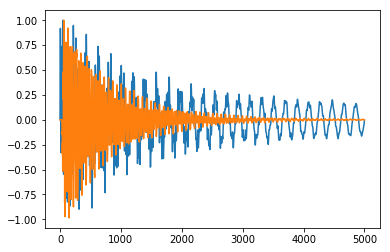

In [30]:
'''
Architecture design for the structured optimization. See the paper for more info.
'''
W1,W2,mat,dampf,bf = Structured_Optimization(K_final,YY,bf_est,T,perm,C1,C2,maxIteration=2000)

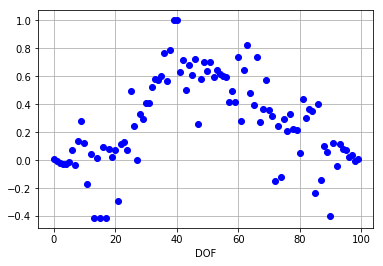

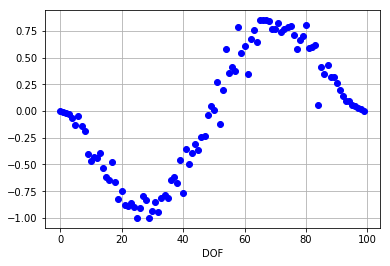

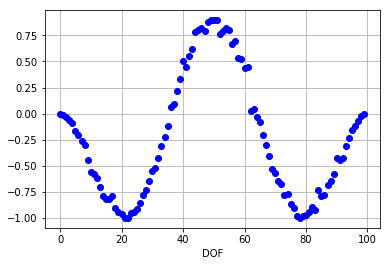

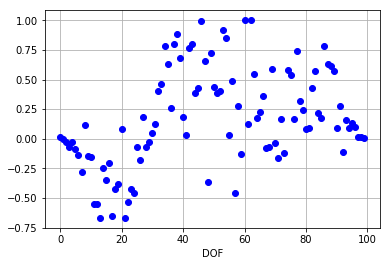

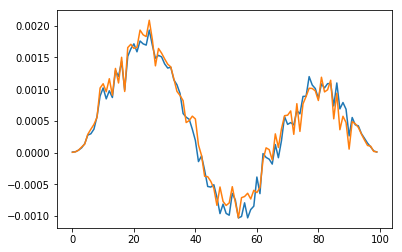

In [31]:
'''
After optimization, we recover structured matrices to read
identified modal properties.
'''
A_opt = W1
B_opt = W2
Y_pred = mat

plt.figure('A matrix')
for i in range(K_final):
    idx = np.argsort(A_opt[:,i])
    A_opt[idx[0],i] = A_opt[idx[1],i]; A_opt[idx[-1],i] = A_opt[idx[-2],i]
    plt.plot(A_opt[:,i]/max(abs(A_opt[:,i])),'bo')
    plt.xlabel('DOF'); plt.grid()
    plt.savefig(("42_struct"+str(num_vcl)+"_mode"+ str(i)+ ".eps"), dpi=600)
    plt.show()

plt.figure('predict vs. actual')
plt.plot(Y_pred[:,1000])
plt.plot(YY[:,1000])
plt.show()

In [33]:
def macFinder(vec,vecx,mode):
    x1 = np.array([0,0.05,0.1,0.2,0.3,0.4,0.5,\
                  0.6,0.7,0.8,0.9,0.95,1.0])
    if mode == 0:
        v1 = np.array([0,1.24523E-05,4.57119E-05,0.000149764,0.000264796,0.000351056,\
                       0.000382142,0.000349283,0.000262407,0.000148021,4.51279E-05,1.23074E-05,0])
    elif mode == 1:
        v1 = np.array([0,3.2093E-05,0.000109361,0.000289783,0.000361408,0.000247792,\
                       -1.31867E-06,-0.000250093,-0.00036299,-0.00029068,-0.000109724,-3.22561E-05,0])
    elif mode == 2:
        v1 = -1*np.array([0,-5.92165E-05,-0.000185035,-0.000362711,-0.000209103,0.000151082,\
                          0.000338181,0.000151022,-0.000209113,-0.000362806,-0.000185262,-5.94074E-05,0])
    elif mode == 3:
        v1 = -1*np.array([0,-9.16667E-05,-0.00025823,-0.000317542,0.000101368,0.000335169,\
                          3.12498E-08,-0.000335286,-0.000101736,0.000317402,0.000258537,9.19719E-05,0])
    f = interpolate.interp1d(x1, abs(v1))
    vNew = f(vecx)
    vR = abs(vec)
    output = np.power(abs(np.matmul(vR.T, vNew)),2)/np.matmul(vR.T,vR)/np.matmul(vNew.T,vNew)
    return output

mac = []
avg = 1
temp = [0,1,2,3]
for i in range(K_final):
    vec = np.convolve(A_opt[:,temp[i]]/min(A_opt[:,temp[i]]), np.ones((avg,))/avg, mode='same')
    vecx = np.linspace(0,1,100)
    mode = i
    mac.append(macFinder(vec,vecx,mode))
    print ('MAC val mode ', str(i), ': ', mac[-1])

MAC val mode  0 :  0.8709842308724627
MAC val mode  1 :  0.968790281910235
MAC val mode  2 :  0.9532264239965347
MAC val mode  3 :  0.6308865216656315


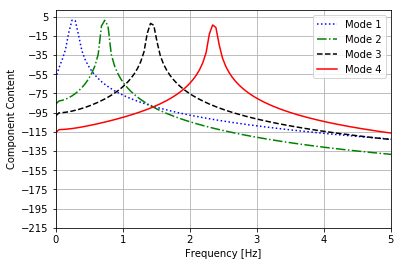

In [34]:
dt = T/float(N)
plt.figure('psd')
for i in range(K_final):
  plt.psd(B_opt[temp[i],:]/max(B_opt[temp[i],:]), 1024, 1 / dt, color=color[i],linestyle=marker[i])
  plt.xlim([0,5])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Component Content') 
plt.legend(['Mode 1','Mode 2','Mode 3','Mode 4'])
plt.savefig(("42_struct"+str(num_vcl)+"_FICAModes_psdModes.eps"), dpi=600)
plt.show()

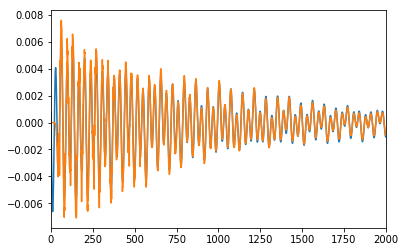

In [35]:
'''
Comparing time signals: prediction vs. actual
'''
plt.figure('predict vs. actual')
plt.plot(Y_pred[25,:])
plt.plot(YY[25,:])
plt.xlim([0,2000])
plt.show()

(0, 5)

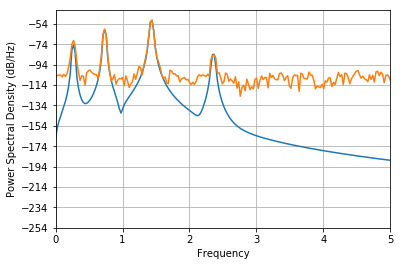

In [36]:
'''
And comparison in Frequency domain
'''
plt.figure('predict vs. actual')
plt.psd(Y_pred[10,:],2048,1/0.02)
plt.psd(YY[10,:],2048,1/0.02)
plt.xlim([0,5])

dampings =  [[0.01489573 0.00662997 0.00573525 0.00471024]]
frequencies =  [[0.26562062 0.7320795  1.43150491 2.35607855]]


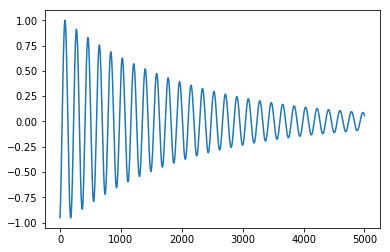

In [37]:
'''
Estimated damping and frequency valus:
'''

vals = dampf
print('dampings = ', vals.T)
print('frequencies = ', bf.T)

i = 0
plt.plot(B_opt[i,:]/max(abs(B_opt[i,:])))
plt.show()

### END OF THE CODE